# This file explores and plots affordable housing units in Morris County

In [170]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from random import sample
import shapely.ops as so
import matplotlib.patches as mpatches

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

affhouse_main = pd.read_csv('./2023-morris-county-affordable-housing-map-and-resources.csv')
#https://www.morriscountynj.gov/files/sharedassets/public/v/1/departments/human-services/2023-morris-county-affordable-housing-map-and-resources.pdf
towns_shapefile = "../Data/morrisMunicipalities/Municipalities.shp"
gdf = gpd.read_file(towns_shapefile).reset_index()
gdf = gdf.to_crs(4326)

In [171]:
affhouse_main

,Map ID,Municipality,Development,Location,Total Units,L&M Units,Age Restricted,Rental,Sale,Status
0,BTN-01,Boonton,Bina Court,Chestnut Street,33,6,Yes,Yes,No,Under Construction
1,BTN-02,Boonton,Chestnut Court/BHA,125 Chestnut Street,14,14,Yes,Yes,No,Completed
2,BTN-03,Boonton,Packard Building,128 Monroe St.,65,12,No,Yes,No,Under Construction
3,BTP-01,Boonton Twp.,Bina Court (Boonton Twp),120 Powerville Rd,38,8,No,Yes,No,Under Construction
4,BTP-02,Boonton Twp.,Brae-Loch (Maltz),Brae Loch Drive,115,24,No,No,Yes,Completed
...,...,...,...,...,...,...,...,...,...,...
188,WAS-02,Washington,Homeless Solutions,37 Drakestown Road,10,10,No,Yes,No,Completed
189,WHT-01,Wharton,57 South Main Street - Family,57 South Main Street,11,11,No,Yes,No,Approved
190,WHT-02,Wharton,Centennial Court,100 North Main Street,100,100,Yes,Yes,No,Completed
191,WHT-03,Wharton,Edgewater / River Place,100 West Dewey Avenue,67,14,No,Yes,No,Completed


## 1.) Need to rename town names to match the official Morris County Registry

In [172]:
change_dict = {'Boonton':'Boonton Town','Boonton Twp.':'Boonton Township','Butler':'Butler Borough',
               'Chatham Boro.':'Chatham Borough','Chatham Twp.':'Chatham Township','Chester Boro.':'Chester Borough','Denville':'Denville Township','Dover':'Dover Town','East Hanover':'East Hanover Township','Florham Park':'Florham Park Borough','Hanover':'Hanover Township','Harding':'Harding Township','Jefferson':'Jefferson Township','Kinnelon':'Kinnelon Borough','Lincoln Park':'Lincoln Park Borough','Long Hill':'Long Hill Township','Madison':'Madison Borough','Mendham Boro.':'Mendham Borough','Mendham Twp.':'Mendham Township','Mine Hill':'Mine Hill Township','Montville':'Montville Township',
               'Morris Twp.':'Morris Township','Morris Plains':'Morris Plains Borough','Morristown':'Morristown Town',
               'Mountain Lakes':'Mountain Lakes Borough','Mount Arlington':'Mount Arlington Borough','Mount Olive':'Mount Olive Township','Netcong':'Netcong Borough','Parsippany':'Parsippany-Troy Hills Township','Pequannock':'Pequannock Township','Randolph':'Randolph Township','Riverdale':'Riverdale Borough','Rockaway Boro.':'Rockaway Borough','Rockaway Twp.':'Rockaway Township','Roxbury':'Roxbury Township','Washington':'Washington Township','Wharton':'Wharton Borough'}
               #'Chester township':'Chester Township',
               #'Victory Gardens borough':'Victory Gardens Borough',
               #
affhouse_main.replace({'Municipality': change_dict}, inplace=True)

## 2.) Create function that plots all affordable housing units based on unit type 

In [192]:
from matplotlib.patches import Circle
def plot_func(subset, ax, df, num):
    """
    This function returns first computes the total units in each county based on the unit type (Completed, Under Construction, or Approved). Then this function normalizes those values between 0.1 and 1. Then this function uses an axis and fills in each town with varying transparency. The transparency for each county is defined by its normalized unit count. Returns the subplot axis object.
    """
    colors = ['darkorange','darkblue','darkgreen']
    
    affhouse = df.copy()
    affhouse = affhouse[affhouse.Status==subset]
    affhouse["Total Units"] = affhouse["Total Units"].str.split(',').str.join('') # Remove commas
    affhouse = affhouse[affhouse["Total Units"].notna()] # Removes Nas
    affhouse["Total Units"] = affhouse["Total Units"].astype(int) # Convert str to int
    
    grouped = affhouse.copy().groupby("Municipality")["Total Units"].sum().reset_index() # group by town
    gmin = grouped["Total Units"].min()
    gmax = grouped["Total Units"].max()
    g_scaled = [(x-gmin)/(gmax-gmin) for x in grouped["Total Units"]]
    g_scaled = [(x * (1 - 0.1)) + 0.1 for x in g_scaled]
    grouped["Scaled"] = g_scaled
    
    color_labels = [colors[num],colors[num]]
    color_patches = [mpatches.Patch(color=color_labels[0]), mpatches.Patch(color=color_labels[0])]
    check = True
    handle = []
    for i in range(39): # Super messy, but annoying to deal with plt and ax for legend
        # Plot polygon
        town = gdf.loc[gdf.index[i]]
        multiplier = grouped[grouped.Municipality == town.Label]
        if len(multiplier) == 0:
            multiplier = 0.1
        else:
            multiplier = multiplier.Scaled.values[0]
        if town.geometry.geom_type == 'Polygon':
            x, y = town.geometry.exterior.xy
            label = None
            if multiplier == grouped.Scaled.max():
                label = int(grouped["Total Units"].max())
                handle.append(label)
            elif multiplier == grouped.Scaled.min() and check:
                label = 0
                handle.append(label)
                check = False
            ax.fill(x, y, alpha=multiplier, fc=colors[num], ec='none', label=label)
        elif town.geometry.geom_type == 'MultiPolygon':
            new_shape = so.unary_union(town.geometry)
            for geom in new_shape.geoms:
                x, y = geom.exterior.xy
                label = None
                if multiplier == grouped.Scaled.max():
                    label = int(grouped["Total Units"].max())
                    handle.append(label)
                elif multiplier == grouped.Scaled.min() and check:
                    label = 0
                    handle.append(label)
                    check = False
                ax.fill(x, y, alpha=multiplier, fc=colors[num], ec='none', label=label)
    
    center = (-74.7, 40.87)
    radius = 0.06
    circle = Circle(center, radius, fill=False,  color='r')
    ax.add_patch(circle)
    center = (-74.45, 40.85)
    radius = 0.08
    circle = Circle(center, radius, fill=False,  color='r')
    ax.add_patch(circle)
    
    ax.set_title(subset) # Set individual legends for each plot
    handles, labels = ax.get_legend_handles_labels() 
    cnt = 0
    for lh in labels:
        if lh == grouped.Scaled.min():
            handles[cnt].set_alpha(0.1)
            cnt += 1
    ax.legend(handles=handles, labels=labels)

## 3.) Plot subplot with each respective unit type
##### Unit types: Completed, Under Construction, Approved

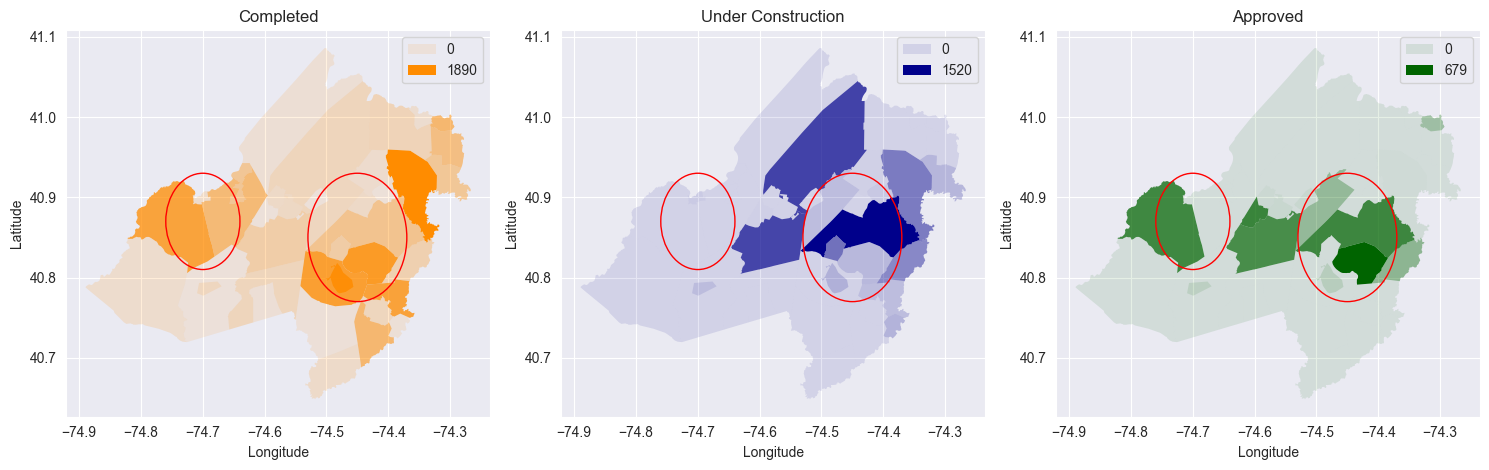

In [194]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)

plot_func("Completed",ax1,affhouse_main,0)
plot_func("Under Construction",ax2,affhouse_main,1)
plot_func("Approved",ax3,affhouse_main,2)

for ax in [ax1, ax2, ax3]:
    ax.set(xlabel='Longitude', ylabel='Latitude')

fig.tight_layout()
plt.savefig("../Figures/plots/morrisAffordableHousing.png")
plt.show();